In [0]:
import os
import json
import numpy as np
from random import randrange
import zipfile

# 1.Preprocess Data


###1.Load Data

In [0]:
def load_data(link):
  
  text = []
  sentiment = []

  for filename in os.listdir(link):
    if filename != '.ipynb_checkpoints':
      file_path = os.path.join(link, filename)
      with open(file_path, encoding = 'unicode_escape') as f:
        dic = json.load(f)

        for k, v in dic['text'].items():
          text.append(v)
        for k, v in dic['sentiment'].items():
          sentiment.append(v)
  return text, sentiment

In [0]:
def preprocess_data(text, sentiment):
  # 80-20 split
  combo = [list(i) for i in zip(text, sentiment)]
  
  combo_test = []

  test_size = int(len(combo)*0.2)
  while len(combo_test) < test_size:
    index = randrange(len(combo))
    combo_test.append(combo.pop(index))
  
  x_train = []
  y_train = []
  x_test = []
  y_test = []
  # x, y split
  for line in combo:
    x_train.append(line[0])
    if line[1] in ['Positive', 'positive', 'postive']:
      y_train.append(2)
    elif line[1] in ['Neutral', 'neutral', 'neutra', 'neutra;', 'Neural']:
      y_train.append(1)
    elif line[1] in ['Negative', 'negative', 'Negetive']:
      y_train.append(0)
    else:
      print('error in sentiment label {}'.format(line[1]))
  for line in combo_test:
    x_test.append(line[0])
    if line[1] in ['Positive', 'positive', 'postive']:
      y_test.append(2)
    elif line[1] in ['Neutral', 'neutral', 'neutra', 'neutra;', 'Neural']:
      y_test.append(1)
    elif line[1] in ['Negative', 'negative', 'Negetive']:
      y_test.append(0)
    else:
      print('error in sentiment label {}'.format(line[1]))
      
  return (x_train, y_train), (x_test, y_test)

In [0]:
link = 'drive/INFO7374_NeuralNetwork&AI/Assignment_3/data/updated-json-files'
text, sentiment = load_data(link)
(x_train, y_train), (x_test, y_test) = preprocess_data(text, sentiment)

In [0]:
# convert to one-hot encoding

from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [0]:
len(x_train), len(x_test)

(1316, 328)

### 2.Tokenize The Data

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut reviews after 100 words
training_samples = 1000  # We will be training on 1000 samples
validation_samples = 316  # We will be validating on 316 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

sequences_test = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(sequences_test, maxlen=maxlen)
y_test = np.asarray(y_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(y_train)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 5792 unique tokens.
Shape of data tensor: (1316, 100)
Shape of label tensor: (1316, 3)


# 2.Experiment -  Trainig From Scratch

Observation: seems not a good idea due to poor accuracy result and the fact that data points is too limited

In [0]:
embedding_dim = 300

In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

optimizer = optimizers.Adam(lr=0.1)
loss = 'categorical_crossentropy'
epochs = 200
batch_size = 54

model.compile(optimizer= optimizer,
              loss = loss,
              metrics=['acc'])

history_6 = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    callbacks = callbacks_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 300)          3000000   
_________________________________________________________________
flatten_7 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                960032    
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 99        
Total params: 3,960,131
Trainable params: 3,960,131
Non-trainable params: 0
_________________________________________________________________
Train on 1000 samples, validate on 316 samples
Epoch 1/200
1000/1000 [==============================] - 2s 2ms/step - loss: 7.3150 - acc: 0.5070 - val_loss: 7.5490 - val_acc: 0.5316
Epoch 2/200
1000/1000 [==============================] - 0s 213us/step - loss: 7.7

# 3.Experiment - Freezed Embedding Layer - GloVe

## 3.1 Embedding_dim = 100

### 3.1.1 Training

In [0]:
# Load Glove data
    
with zipfile.ZipFile('drive/INFO7374_NeuralNetwork&AI/Assignment_3/data/glove.6B.zip','r') as zip_ref:
   zip_ref.extractall('')

In [0]:
embeddings_index = {}

with open('glove.6B.100d.txt') as f:
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
# set dimemsions (# features for each word vector) for embedding layer
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [0]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.callbacks import EarlyStopping

In [0]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, weights = [embedding_matrix], trainable = False, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 99        
Total params: 1,320,131
Trainable params: 320,131
Non-trainable params: 1,000,000
_________________________________________________________________


In [0]:
#define callbacks

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

In [0]:
optimizer = optimizers.SGD(lr=0.01, nesterov=True)
loss = 'categorical_crossentropy'
epochs = 200
batch_size = 32

model.compile(optimizer= optimizer,
              loss = loss,
              metrics=['acc'])

history_1 = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks_list)

model.save_weights('model_1.h5')

Train on 1000 samples, validate on 316 samples
Epoch 1/200
1000/1000 [==============================] - 1s 623us/step - loss: 0.0162 - acc: 0.9990 - val_loss: 2.5002 - val_acc: 0.6013
Epoch 2/200
1000/1000 [==============================] - 0s 126us/step - loss: 0.0162 - acc: 0.9990 - val_loss: 2.5003 - val_acc: 0.6013
Epoch 3/200
1000/1000 [==============================] - 0s 121us/step - loss: 0.0162 - acc: 0.9990 - val_loss: 2.5003 - val_acc: 0.6013
Epoch 4/200
1000/1000 [==============================] - 0s 134us/step - loss: 0.0162 - acc: 0.9990 - val_loss: 2.5003 - val_acc: 0.6013
Epoch 5/200
1000/1000 [==============================] - 0s 124us/step - loss: 0.0162 - acc: 0.9990 - val_loss: 2.5004 - val_acc: 0.6013
Epoch 00005: early stopping


In [0]:
optimizer = optimizers.SGD(lr=0.001, nesterov=True)
loss = 'categorical_crossentropy'
epochs = 100
batch_size = 32

model.compile(optimizer= optimizer,
              loss = loss,
              metrics=['acc'])

history_2 = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks_list )

model.save_weights('model_2.h5')

Train on 1000 samples, validate on 316 samples
Epoch 1/100
1000/1000 [==============================] - 1s 778us/step - loss: 0.0162 - acc: 0.9990 - val_loss: 2.5006 - val_acc: 0.6013
Epoch 2/100
1000/1000 [==============================] - 0s 125us/step - loss: 0.0162 - acc: 0.9990 - val_loss: 2.5006 - val_acc: 0.6013
Epoch 3/100
1000/1000 [==============================] - 0s 123us/step - loss: 0.0162 - acc: 0.9990 - val_loss: 2.5006 - val_acc: 0.6013
Epoch 4/100
1000/1000 [==============================] - 0s 126us/step - loss: 0.0162 - acc: 0.9990 - val_loss: 2.5007 - val_acc: 0.6013
Epoch 5/100
1000/1000 [==============================] - 0s 130us/step - loss: 0.0162 - acc: 0.9990 - val_loss: 2.5007 - val_acc: 0.6013
Epoch 00005: early stopping


In [0]:
optimizer = optimizers.Adam(lr=0.001)
loss = 'categorical_crossentropy'
epochs = 100
batch_size = 32

model.compile(optimizer= optimizer,
              loss = loss,
              metrics=['acc'])

history_3 = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks_list)

model.save_weights('model_3.h5')

Train on 1000 samples, validate on 316 samples
Epoch 1/100
1000/1000 [==============================] - 1s 883us/step - loss: 0.0248 - acc: 0.9950 - val_loss: 2.6093 - val_acc: 0.5823
Epoch 2/100
1000/1000 [==============================] - 0s 169us/step - loss: 0.0600 - acc: 0.9820 - val_loss: 2.4021 - val_acc: 0.6171
Epoch 3/100
1000/1000 [==============================] - 0s 175us/step - loss: 0.0219 - acc: 0.9970 - val_loss: 2.6868 - val_acc: 0.6044
Epoch 4/100
1000/1000 [==============================] - 0s 202us/step - loss: 0.0295 - acc: 0.9950 - val_loss: 3.0276 - val_acc: 0.6234
Epoch 5/100
1000/1000 [==============================] - 0s 167us/step - loss: 0.0202 - acc: 0.9980 - val_loss: 2.8011 - val_acc: 0.5823
Epoch 6/100
1000/1000 [==============================] - 0s 158us/step - loss: 0.0198 - acc: 0.9980 - val_loss: 2.9315 - val_acc: 0.6076
Epoch 00006: early stopping


In [0]:
optimizer = optimizers.Adam(lr=0.01)
loss = 'categorical_crossentropy'
epochs = 100
batch_size = 32

model.compile(optimizer= optimizer,
              loss = loss,
              metrics=['acc'])

history_4 = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks_list)

model.save_weights('model_4.h5')

Train on 1000 samples, validate on 316 samples
Epoch 1/100
1000/1000 [==============================] - 1s 911us/step - loss: 5.7507 - acc: 0.6190 - val_loss: 6.0806 - val_acc: 0.6139
Epoch 2/100
1000/1000 [==============================] - 0s 168us/step - loss: 5.8155 - acc: 0.6240 - val_loss: 5.7280 - val_acc: 0.6329
Epoch 3/100
1000/1000 [==============================] - 0s 153us/step - loss: 5.2341 - acc: 0.6630 - val_loss: 5.8223 - val_acc: 0.6139
Epoch 4/100
1000/1000 [==============================] - 0s 153us/step - loss: 5.4282 - acc: 0.6460 - val_loss: 5.5876 - val_acc: 0.6456
Epoch 5/100
1000/1000 [==============================] - 0s 163us/step - loss: 5.3346 - acc: 0.6600 - val_loss: 5.8533 - val_acc: 0.6171
Epoch 6/100
1000/1000 [==============================] - 0s 152us/step - loss: 5.5716 - acc: 0.6460 - val_loss: 5.2685 - val_acc: 0.6677
Epoch 7/100
1000/1000 [==============================] - 0s 154us/step - loss: 5.1381 - acc: 0.6730 - val_loss: 6.1230 - val_acc: 0

In [0]:
optimizer = optimizers.Adam(lr=0.1)
loss = 'categorical_crossentropy'
epochs = 100
batch_size = 32

model.compile(optimizer= optimizer,
              loss = loss,
              metrics=['acc'])

history_5 = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks_list)

model.save_weights('model_5.h5')

Train on 1000 samples, validate on 316 samples
Epoch 1/100
1000/1000 [==============================] - 1s 933us/step - loss: 7.1728 - acc: 0.5530 - val_loss: 7.5490 - val_acc: 0.5316
Epoch 2/100
1000/1000 [==============================] - 0s 192us/step - loss: 7.7528 - acc: 0.5190 - val_loss: 7.5490 - val_acc: 0.5316
Epoch 3/100
1000/1000 [==============================] - 0s 173us/step - loss: 7.7528 - acc: 0.5190 - val_loss: 7.5490 - val_acc: 0.5316
Epoch 4/100
1000/1000 [==============================] - 0s 173us/step - loss: 7.7528 - acc: 0.5190 - val_loss: 7.5490 - val_acc: 0.5316
Epoch 5/100
1000/1000 [==============================] - 0s 169us/step - loss: 7.7528 - acc: 0.5190 - val_loss: 7.5490 - val_acc: 0.5316
Epoch 00005: early stopping


In [0]:
optimizer = optimizers.Adam(lr=0.1)
loss = 'categorical_crossentropy'
epochs = 200
batch_size = 54

model.compile(optimizer= optimizer,
              loss = loss,
              metrics=['acc'])

history_6 = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks_list)

model.save_weights('model_6.h5')

Train on 1000 samples, validate on 316 samples
Epoch 1/200
1000/1000 [==============================] - 1s 962us/step - loss: 7.7528 - acc: 0.5190 - val_loss: 7.5490 - val_acc: 0.5316
Epoch 2/200
1000/1000 [==============================] - 0s 110us/step - loss: 7.7528 - acc: 0.5190 - val_loss: 7.5490 - val_acc: 0.5316
Epoch 3/200
1000/1000 [==============================] - 0s 104us/step - loss: 7.7528 - acc: 0.5190 - val_loss: 7.5490 - val_acc: 0.5316
Epoch 4/200
1000/1000 [==============================] - 0s 102us/step - loss: 7.7528 - acc: 0.5190 - val_loss: 7.5490 - val_acc: 0.5316
Epoch 5/200
1000/1000 [==============================] - 0s 103us/step - loss: 7.7528 - acc: 0.5190 - val_loss: 7.5490 - val_acc: 0.5316
Epoch 00005: early stopping


### 3.1.2 Plot Confusion Matrix

Model 4 delivers the best accuracy

In [0]:
model.load_weights('model_4.h5')
model.evaluate(x_test, y_test)

328/328 [==============================] - 0s 77us/step


[5.285326236631812, 0.6585365853658537]

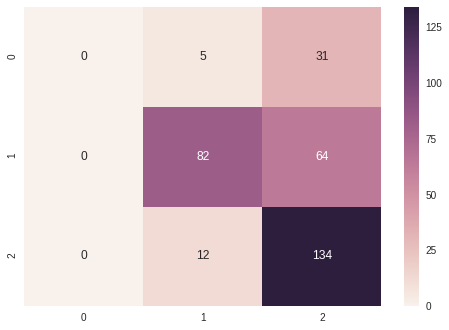

In [0]:
import seaborn as sns
from sklearn import metrics

y_pred = model.predict(x_test)
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(matrix,annot=True,fmt='.5g')

### 3.1.3 Observation: 

- For Negative: None were correctory classified
- For Positive: Accuracy is high
- For Neutral: Ambiguity exists between Nuetral and Positive

## 3.2 Embedding_dim = 300

### 3.2.1 Training

In [0]:
embeddings_index = {}

with open('glove.6B.300d.txt') as f:
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
# set dimemsions (# features for each word vector) for embedding layer
embedding_dim = 300

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [0]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.callbacks import EarlyStopping

In [0]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, weights = [embedding_matrix], trainable = False, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 300)          3000000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                960032    
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 99        
Total params: 3,960,131
Trainable params: 960,131
Non-trainable params: 3,000,000
_________________________________________________________________


In [0]:
#define callbacks

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

In [0]:
optimizer = optimizers.SGD(lr=0.01, nesterov=True)
loss = 'categorical_crossentropy'
epochs = 200
batch_size = 32

model.compile(optimizer= optimizer,
              loss = loss,
              metrics=['acc'])

history_1 = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks_list)

model.save_weights('model_1.h5')

Train on 1000 samples, validate on 316 samples
Epoch 1/200
1000/1000 [==============================] - 1s 1ms/step - loss: 0.9821 - acc: 0.5300 - val_loss: 0.9422 - val_acc: 0.6171
Epoch 2/200
1000/1000 [==============================] - 0s 174us/step - loss: 0.7840 - acc: 0.6960 - val_loss: 0.8738 - val_acc: 0.6234
Epoch 3/200
1000/1000 [==============================] - 0s 169us/step - loss: 0.6424 - acc: 0.7720 - val_loss: 0.8597 - val_acc: 0.5981
Epoch 4/200
1000/1000 [==============================] - 0s 191us/step - loss: 0.5151 - acc: 0.8610 - val_loss: 0.8901 - val_acc: 0.5854
Epoch 5/200
1000/1000 [==============================] - 0s 157us/step - loss: 0.3917 - acc: 0.9100 - val_loss: 0.9797 - val_acc: 0.5665
Epoch 6/200
1000/1000 [==============================] - 0s 179us/step - loss: 0.3193 - acc: 0.9380 - val_loss: 1.0398 - val_acc: 0.6297
Epoch 7/200
1000/1000 [==============================] - 0s 177us/step - loss: 0.2509 - acc: 0.9510 - val_loss: 0.9745 - val_acc: 0.5

In [0]:
optimizer = optimizers.SGD(lr=0.001, nesterov=True)
loss = 'categorical_crossentropy'
epochs = 100
batch_size = 32

model.compile(optimizer= optimizer,
              loss = loss,
              metrics=['acc'])

history_2 = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks_list )

model.save_weights('model_2.h5')

Train on 1000 samples, validate on 316 samples
Epoch 1/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.2063 - acc: 0.9750 - val_loss: 0.8802 - val_acc: 0.6392
Epoch 2/100
1000/1000 [==============================] - 0s 194us/step - loss: 0.1929 - acc: 0.9770 - val_loss: 0.8845 - val_acc: 0.6297
Epoch 3/100
1000/1000 [==============================] - 0s 178us/step - loss: 0.1889 - acc: 0.9770 - val_loss: 0.8891 - val_acc: 0.6297
Epoch 4/100
1000/1000 [==============================] - 0s 174us/step - loss: 0.1856 - acc: 0.9770 - val_loss: 0.8886 - val_acc: 0.6266
Epoch 5/100
1000/1000 [==============================] - 0s 177us/step - loss: 0.1820 - acc: 0.9780 - val_loss: 0.8901 - val_acc: 0.6203
Epoch 00005: early stopping


In [0]:
optimizer = optimizers.Adam(lr=0.001)
loss = 'categorical_crossentropy'
epochs = 100
batch_size = 32

model.compile(optimizer= optimizer,
              loss = loss,
              metrics=['acc'])

history_3 = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks_list)

model.save_weights('model_3.h5')

Train on 1000 samples, validate on 316 samples
Epoch 1/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.4110 - acc: 0.8500 - val_loss: 1.0829 - val_acc: 0.6234
Epoch 2/100
1000/1000 [==============================] - 0s 229us/step - loss: 0.0949 - acc: 0.9760 - val_loss: 1.1846 - val_acc: 0.6519
Epoch 3/100
1000/1000 [==============================] - 0s 216us/step - loss: 0.0326 - acc: 0.9950 - val_loss: 1.3972 - val_acc: 0.6519
Epoch 4/100
1000/1000 [==============================] - 0s 213us/step - loss: 0.0191 - acc: 0.9960 - val_loss: 1.4071 - val_acc: 0.6487
Epoch 5/100
1000/1000 [==============================] - 0s 212us/step - loss: 0.0126 - acc: 0.9980 - val_loss: 1.4127 - val_acc: 0.6361
Epoch 00005: early stopping


In [0]:
optimizer = optimizers.Adam(lr=0.01)
loss = 'categorical_crossentropy'
epochs = 100
batch_size = 32

model.compile(optimizer= optimizer,
              loss = loss,
              metrics=['acc'])

history_4 = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks_list)

model.save_weights('model_4.h5')

Train on 1000 samples, validate on 316 samples
Epoch 1/100
1000/1000 [==============================] - 1s 1ms/step - loss: 7.4520 - acc: 0.5300 - val_loss: 7.5059 - val_acc: 0.5316
Epoch 2/100
1000/1000 [==============================] - 0s 217us/step - loss: 7.7069 - acc: 0.5210 - val_loss: 7.4992 - val_acc: 0.5316
Epoch 3/100
1000/1000 [==============================] - 0s 211us/step - loss: 7.7058 - acc: 0.5210 - val_loss: 7.5060 - val_acc: 0.5316
Epoch 4/100
1000/1000 [==============================] - 0s 228us/step - loss: 7.7056 - acc: 0.5210 - val_loss: 7.5205 - val_acc: 0.5316
Epoch 5/100
1000/1000 [==============================] - 0s 212us/step - loss: 7.7056 - acc: 0.5210 - val_loss: 7.5207 - val_acc: 0.5316
Epoch 00005: early stopping


In [0]:
optimizer = optimizers.Adam(lr=0.1)
loss = 'categorical_crossentropy'
epochs = 100
batch_size = 32

model.compile(optimizer= optimizer,
              loss = loss,
              metrics=['acc'])

history_5 = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks_list)

model.save_weights('model_5.h5')

Train on 1000 samples, validate on 316 samples
Epoch 1/100
1000/1000 [==============================] - 1s 1ms/step - loss: 7.7407 - acc: 0.5190 - val_loss: 7.5490 - val_acc: 0.5316
Epoch 2/100
1000/1000 [==============================] - 0s 227us/step - loss: 7.7376 - acc: 0.5190 - val_loss: 7.5490 - val_acc: 0.5316
Epoch 3/100
1000/1000 [==============================] - 0s 214us/step - loss: 7.7372 - acc: 0.5200 - val_loss: 7.5490 - val_acc: 0.5316
Epoch 4/100
1000/1000 [==============================] - 0s 212us/step - loss: 7.7370 - acc: 0.5200 - val_loss: 7.5490 - val_acc: 0.5316
Epoch 5/100
1000/1000 [==============================] - 0s 208us/step - loss: 7.7369 - acc: 0.5200 - val_loss: 7.5490 - val_acc: 0.5316
Epoch 00005: early stopping


In [0]:
optimizer = optimizers.Adam(lr=0.1)
loss = 'categorical_crossentropy'
epochs = 200
batch_size = 54

model.compile(optimizer= optimizer,
              loss = loss,
              metrics=['acc'])

history_6 = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks_list)

model.save_weights('model_6.h5')

Train on 1000 samples, validate on 316 samples
Epoch 1/200
1000/1000 [==============================] - 1s 1ms/step - loss: 7.7368 - acc: 0.5200 - val_loss: 7.5490 - val_acc: 0.5316
Epoch 2/200
1000/1000 [==============================] - 0s 157us/step - loss: 7.7367 - acc: 0.5200 - val_loss: 7.5490 - val_acc: 0.5316
Epoch 3/200
1000/1000 [==============================] - 0s 140us/step - loss: 7.7367 - acc: 0.5200 - val_loss: 7.5490 - val_acc: 0.5316
Epoch 4/200
1000/1000 [==============================] - 0s 139us/step - loss: 7.7367 - acc: 0.5200 - val_loss: 7.5490 - val_acc: 0.5316
Epoch 5/200
1000/1000 [==============================] - 0s 138us/step - loss: 7.7367 - acc: 0.5200 - val_loss: 7.5490 - val_acc: 0.5316
Epoch 00005: early stopping


### 3.2.2 Plot Confusion Matrix

Model 3 delivers the best accuracy

In [0]:
model.load_weights('model_3.h5')
model.evaluate(x_test, y_test)

328/328 [==============================] - 0s 91us/step


[1.5599273181543118, 0.6128048780487805]

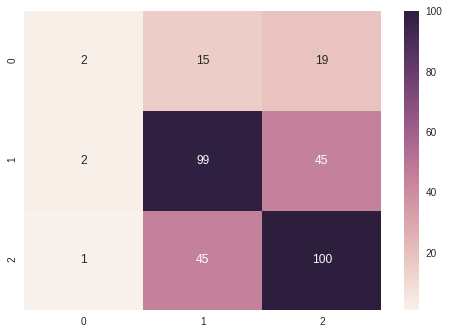

In [0]:
import seaborn as sns
from sklearn import metrics

y_pred = model.predict(x_test)
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(matrix,annot=True,fmt='.5g')

### 3.2.3 Observation:

- Positive: 67.8% acc
- Neutral: 68.4% acc
- Negative: 5.5%

Most negative are falsely predicted

# 4.Experiment - Freezed Embedding Layer + CNN - GloVe

In [0]:
import keras
from keras import regularizers
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.preprocessing import sequence

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs

## 4.1 Embedding_dim = 100

### 4.1.1 Training

In [0]:
embeddings_index = {}

with open('glove.6B.100d.txt') as f:
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
# set dimemsions (# features for each word vector) for embedding layer
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [0]:
#training params
batch_size = 256 
num_epochs = 50


#model parameters
num_filters = 64 
embedding_dim = 100 
weight_decay = 1e-4

optimizer = optimizers.Adam(lr=0.001)

In [0]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim,
          weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(3, activation='softmax'))  #multi-label (k-hot encoding)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 100, 64)           44864     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 50, 64)            0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 50, 64)            28736     
_________________________________________________________________
global_max_pooling1d_15 (Glo (None, 64)                0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 32)                2080      
__________

In [0]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

#model training
hist = model.fit(x_train, 
                 y_train, 
                 batch_size=batch_size, 
                 epochs=num_epochs, 
                 callbacks=callbacks_list, 
                 validation_split=0.1, 
                 shuffle=True, 
                 verbose=2)

model.save_weights('model_txtCNN_1.h5')

Train on 900 samples, validate on 100 samples
Epoch 1/50
 - 0s - loss: 0.0525 - acc: 0.9889 - val_loss: 1.0812 - val_acc: 0.7000
Epoch 2/50
 - 0s - loss: 0.0464 - acc: 0.9956 - val_loss: 1.1763 - val_acc: 0.6000
Epoch 3/50
 - 0s - loss: 0.0493 - acc: 0.9911 - val_loss: 1.1026 - val_acc: 0.7000
Epoch 4/50
 - 0s - loss: 0.0485 - acc: 0.9911 - val_loss: 1.1636 - val_acc: 0.6400
Epoch 5/50
 - 0s - loss: 0.0402 - acc: 0.9922 - val_loss: 1.1510 - val_acc: 0.7300
Epoch 00005: early stopping


In [0]:
#training params
batch_size = 256 
num_epochs = 50


#model parameters
num_filters = 64 
embedding_dim = 100 
weight_decay = 1e-4

optimizer = optimizers.Adam(lr=0.01)

model = Sequential()
model.add(Embedding(max_words, embedding_dim,
          weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(3, activation='softmax'))  #multi-label (k-hot encoding)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

#model training
hist = model.fit(x_train, 
                 y_train, 
                 batch_size=batch_size, 
                 epochs=num_epochs, 
                 callbacks=callbacks_list, 
                 validation_split=0.1, 
                 shuffle=True, 
                 verbose=2)

model.save_weights('model_txtCNN_2.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 100, 64)           44864     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 50, 64)            28736     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 64)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 32)                2080      
__________

In [0]:
#training params
batch_size = 256 
num_epochs = 50


#model parameters
num_filters = 128 
embedding_dim = 100 
weight_decay = 1e-4

optimizer = optimizers.Adam(lr=0.001)

model = Sequential()
model.add(Embedding(max_words, embedding_dim,
          weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(3, activation='softmax'))  #multi-label (k-hot encoding)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

#model training
hist = model.fit(x_train, 
                 y_train, 
                 batch_size=batch_size, 
                 epochs=num_epochs, 
                 callbacks=callbacks_list, 
                 validation_split=0.1, 
                 shuffle=True, 
                 verbose=2)

model.save_weights('model_txtCNN_2.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 100, 128)          89728     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 50, 128)           0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 50, 128)           114816    
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 128)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 32)                4128      
__________

### 4.1.2 Plot Confusion Matrix

Model 1 delivers the best accuracy

In [0]:
# model.load_weights('model_txtCNN_1.h5')
model.evaluate(x_test, y_test)

328/328 [==============================] - 0s 347us/step


[1.1832514274411086, 0.6432926829268293]

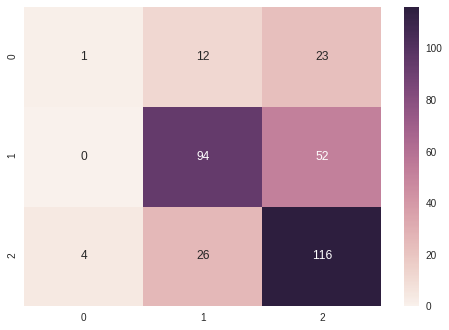

In [0]:
import seaborn as sns
from sklearn import metrics

y_pred = model.predict(x_test)
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(matrix,annot=True,fmt='.5g')

### 4.1.3 Observation: 

- For Negative: 2.7% accuracy
- For Positive: 79.5% accuracy
- For Neutral: 64.4% accuracy

## 4.2 Embedding_dim = 300

### 4.2.1 Training

In [0]:
embeddings_index = {}

with open('glove.6B.300d.txt') as f:
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
# set dimemsions (# features for each word vector) for embedding layer
embedding_dim = 300

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [0]:
#training params
batch_size = 256 
num_epochs = 50


#model parameters
num_filters = 64 
embedding_dim = 300 
weight_decay = 1e-4

optimizer = optimizers.Adam(lr=0.001)

In [0]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim,
          weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(3, activation='softmax'))  #multi-label (k-hot encoding)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 100, 300)          3000000   
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 100, 64)           134464    
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 50, 64)            0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 50, 64)            28736     
_________________________________________________________________
global_max_pooling1d_16 (Glo (None, 64)                0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 32)                2080      
__________

In [0]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

#model training
hist = model.fit(x_train, 
                 y_train, 
                 batch_size=batch_size, 
                 epochs=num_epochs, 
                 callbacks=callbacks_list, 
                 validation_split=0.1, 
                 shuffle=True, 
                 verbose=2)

model.save_weights('model_txtCNN_1.h5')

Train on 900 samples, validate on 100 samples
Epoch 1/50
 - 4s - loss: 1.0663 - acc: 0.4322 - val_loss: 1.0170 - val_acc: 0.4900
Epoch 2/50
 - 0s - loss: 0.9562 - acc: 0.5611 - val_loss: 0.9688 - val_acc: 0.6300
Epoch 3/50
 - 0s - loss: 0.9119 - acc: 0.6089 - val_loss: 0.9334 - val_acc: 0.6600
Epoch 4/50
 - 0s - loss: 0.8673 - acc: 0.6211 - val_loss: 0.9013 - val_acc: 0.6200
Epoch 5/50
 - 0s - loss: 0.8290 - acc: 0.6567 - val_loss: 0.8717 - val_acc: 0.6600
Epoch 6/50
 - 0s - loss: 0.7830 - acc: 0.6778 - val_loss: 0.8594 - val_acc: 0.6700
Epoch 7/50
 - 0s - loss: 0.7455 - acc: 0.7022 - val_loss: 0.8260 - val_acc: 0.6600
Epoch 8/50
 - 0s - loss: 0.7045 - acc: 0.7233 - val_loss: 0.7938 - val_acc: 0.6900
Epoch 9/50
 - 0s - loss: 0.6646 - acc: 0.7356 - val_loss: 0.7920 - val_acc: 0.6800
Epoch 10/50
 - 0s - loss: 0.6120 - acc: 0.7611 - val_loss: 0.7854 - val_acc: 0.7100
Epoch 11/50
 - 0s - loss: 0.5683 - acc: 0.7844 - val_loss: 0.8244 - val_acc: 0.5600
Epoch 12/50
 - 0s - loss: 0.5245 - acc:

In [0]:
#training params
batch_size = 256 
num_epochs = 50


#model parameters
num_filters = 64 
embedding_dim = 300 
weight_decay = 1e-4

optimizer = optimizers.Adam(lr=0.01)

model = Sequential()
model.add(Embedding(max_words, embedding_dim,
          weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(3, activation='softmax'))  #multi-label (k-hot encoding)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

#model training
hist = model.fit(x_train, 
                 y_train, 
                 batch_size=batch_size, 
                 epochs=num_epochs, 
                 callbacks=callbacks_list, 
                 validation_split=0.1, 
                 shuffle=True, 
                 verbose=2)

model.save_weights('model_txtCNN_2.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 100, 300)          3000000   
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 100, 64)           134464    
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 50, 64)            0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 50, 64)            28736     
_________________________________________________________________
global_max_pooling1d_17 (Glo (None, 64)                0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 32)                2080      
__________

In [0]:
#training params
batch_size = 256 
num_epochs = 50


#model parameters
num_filters = 128 
embedding_dim = 300 
weight_decay = 1e-4

optimizer = optimizers.Adam(lr=0.001)

model = Sequential()
model.add(Embedding(max_words, embedding_dim,
          weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(3, activation='softmax'))  #multi-label (k-hot encoding)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

#model training
hist = model.fit(x_train, 
                 y_train, 
                 batch_size=batch_size, 
                 epochs=num_epochs, 
                 callbacks=callbacks_list, 
                 validation_split=0.1, 
                 shuffle=True, 
                 verbose=2)

model.save_weights('model_txtCNN_3.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 100, 300)          3000000   
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 100, 128)          268928    
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 50, 128)           0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 50, 128)           114816    
_________________________________________________________________
global_max_pooling1d_19 (Glo (None, 128)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 32)                4128      
__________

### 4.2.2 Plot Confusion Matrix

Model 1 delivers the best accuracy

In [0]:
# model.load_weights('model_txtCNN_3.h5')
model.evaluate(x_test, y_test)

328/328 [==============================] - 0s 229us/step


[0.8450581896595839, 0.6859756097560976]

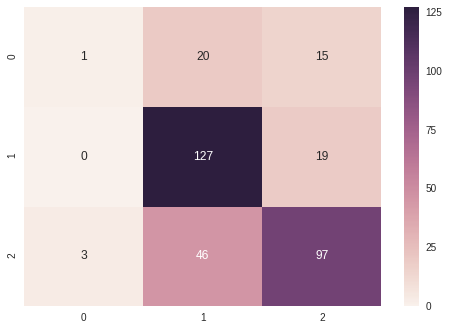

In [0]:
import seaborn as sns
from sklearn import metrics

y_pred = model.predict(x_test)
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(matrix,annot=True,fmt='.5g')

### 4.2.3 Observation: 

- For Negative: 2.7% accuracy
- For Positive: 66.4% accuracy
- For Neutral: 86.9% accuracy